# Distribution fitting with pytorch 

## Overview 
This is a POC of using pytorch to do distribution fitting. This might be useful because it might give us more control over things like parameter initialization, learning rate, and optimization configuration. Also, it makes it easy to track how estimates change during the optimization process. This can help us identify cases where we're getting stuck in local minima. 

- Use the likelihood function of weibull 2p as the loss function 
- The "model" is really just the shape and scale params. During training, we run N iterations. In each iteration, we use the current estimated params to evaluate the loss, calculate gradient, and take an optimization step. 
- After some experimentation, the following config seems to work well: 
  - Initialize weights/params with `weights = torch.distributions.Uniform(0, 4).sample((2,))`
  - Use optimizer `torch.optim.Adam(m.parameters(), lr=.01, amsgrad=True)`
  - Use n=2000 iterations in training loop (similar to epochs in more standard ML problems)


Other things to try: 
- For both LBFGS and Adam, how to deal with the case where param estimate becomes negative? When that happens at a certain optimization step, the loss for that step in nan, and then all further steps fail.
- Check why Adam can't deal estimate large scale values (larger than 1.0). Confirm that LBFGS can. 
- Confirm that it makes sense that the loss function can become negative. In most of the good fits I see, this is the case. 
- Set up tracking of validation loss + early stopping
- Fit mixtures of Weibulls instead of single weibulls. See function `weibull_mixture_nll` below. We would also have to change the `Model` class to have six weights: `p1, p2, shape1, shape2, scale1, scale2`. However, keep in mind that the goal is not perfect fit. Focus on interpretability and business purpose over perfect fit. 





## References: 
- [How to use Pytorch as a general optimizer](https://towardsdatascience.com/how-to-use-pytorch-as-a-general-optimizer-a91cbf72a7fb)
- [pytorch Adam vs LBFGS](https://soham.dev/posts/linear-regression-pytorch/)

In [1]:
import numpy as np
from scipy.stats import weibull_min, beta, gaussian_kde
import torch
import torch.nn as nn
from torch.functional import F
from torch.autograd import Variable
import plotly.graph_objects as go
import matplotlib.pyplot as plt 

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Data setup 

In [2]:
np.random.seed(2023)

n = 100
shape = 9.98
scale = 4890

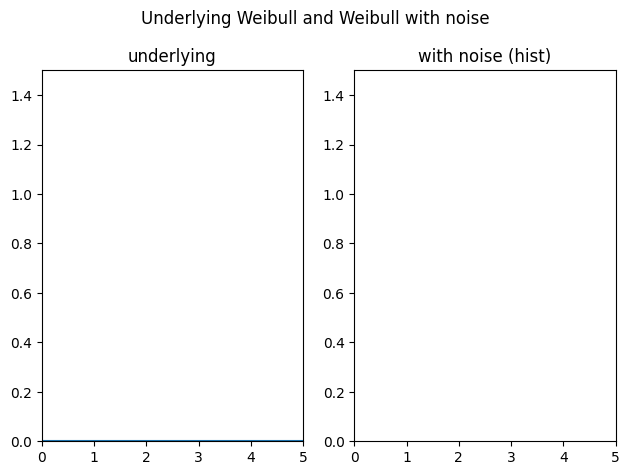

In [3]:
#generate points for weibull, set location parameter to 0 - this is 2-parameter because loc is 0
weibull_data = weibull_min.rvs(c=shape, scale=scale, loc=0, size=n)

#add noise, mean = 0, sd = 0.1 for the same sample size
noise = np.random.normal(0, 0.1, n)  
weibull_data = weibull_data + noise
#all positive data
weibull_data = np.abs(weibull_data) + 1e-4

#generate the x values to be used for generating the pdf
curve_x = np.linspace(0, 5, 1000)
#generate the pdf with the same parameters that were used for generating the data
weibull_pdf = weibull_min.pdf(curve_x, shape, scale=scale)

title='Underlying Weibull and Weibull with noise'
subs = ['underlying', 'with noise (hist)']
fig, ax = plt.subplots(1, 2)
ax[0].plot(curve_x, weibull_pdf)
ax[1].hist(weibull_data, bins=10, density=True)

for idx in range(2): 
    ax[idx].set_xlim(0, 5)
    ax[idx].set_ylim(0, 1.5)
    ax[idx].set_title(subs[idx])
plt.suptitle(title)
fig.tight_layout()
fig.show()

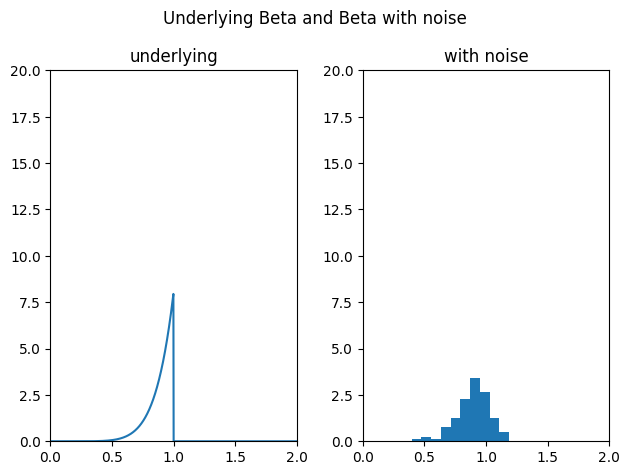

In [4]:
#generate non-weibull data, following beta distribution
beta_data = beta.rvs(a=8, b=1, size=n)
#add noise
beta_data = beta_data + noise
#all positive data
beta_data = np.abs(beta_data)

#generate the pdf with the same parameters that were used for generating the data
curve_x = np.linspace(0, 2, 1000)
beta_pdf = beta.pdf(curve_x, a=8, b=1)

title='Underlying Beta and Beta with noise'
subs = ['underlying', 'with noise']
fig, ax = plt.subplots(1, 2)
ax[0].plot(curve_x, beta_pdf)
ax[1].hist(beta_data, density=True)

for idx in range(2): 
    ax[idx].set_xlim(0, 2.0)
    ax[idx].set_ylim(0, 20.0)
    ax[idx].set_title(subs[idx])
plt.suptitle(title)
fig.tight_layout()
fig.show()

****
# Utility functions 

In [5]:
def plot_weibull_distributions(params1, params2):
    shape1, scale1 = params1
    shape2, scale2 = params2
    
    # Create Weibull distribution objects
    weibull_dist1 = weibull_min(c=shape1, scale=scale1)
    weibull_dist2 = weibull_min(c=shape2, scale=scale2)
    
    # Generate x values for the plot
    x = np.linspace(0, max(scale1, scale2) * 2, 1000)
    
    # Calculate probability density function values for each distribution
    pdf1 = weibull_dist1.pdf(x)
    pdf2 = weibull_dist2.pdf(x)
    
    # Plot the distributions
    plt.plot(x, pdf1, label=f'Weibull ({shape1:.2f}, {scale1:.2f})')
    plt.plot(x, pdf2, label=f'Weibull ({shape2:.2f}, {scale2:.2f})')
    plt.xlabel('x')
    plt.ylabel('Probability Density')
    plt.legend()
    plt.title('Weibull Distributions')
    plt.show()

****
# Model setup 

In [6]:
class Model(nn.Module):
    """Custom Pytorch model for gradient optimization.
    """
    def __init__(self):        
        super().__init__()
        # initialize weights with random numbers
        weights = torch.distributions.Uniform(0, 4).sample((2,))
        # make weights torch parameters
        self.weights = nn.Parameter(weights)        
        
    def forward(self, X):
        """Implement function to be optimised. In this case, a 2-parameter Weibull
        distribution (f(x) = (k / lambda) * (x / lambda)^(k - 1) * exp(-(x / lambda)^k)),
        """
        lambda_, k = self.weights
        weibull_pdf = (k / lambda_) * (X / lambda_)**(k - 1) * torch.exp(-((X / lambda_)**k))
        
        return weibull_pdf


In [7]:
def train_loop(model, optimizer, data_tensor, n=1000): 
    losses = []
    print('scale, shape, loss \n')
    for i in range(n):
        preds = model(data_tensor)
        # loss = F.mse_loss(preds, data_tensor).sqrt()  # todo: use neg log likelihood? 
        lambda_, k = model.weights
        loss = weibull_nll(data_tensor, lambda_, k)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        losses.append(loss) 
        if i % 100 == 0: 
            print(f'iter {i}: {lambda_}, {k}, {loss}')
        
    return losses

In [8]:
def weibull_nll(data, lambda_, k): 
    log_likelihood = torch.sum(torch.log(k / lambda_) + (k - 1) * torch.log(data / lambda_) - (data / lambda_) ** k)
    nll = -log_likelihood
    return nll

In [9]:
def weibull_mixture_nll(data, alphas, betas, pis):
    # todo: verify that this is correct 
    data = data.unsqueeze(1).expand_as(alphas)
    likelihood = pis * torch.exp((torch.log(data) - torch.log(alphas)) * betas - (data / alphas) ** betas)
    log_likelihood = torch.log(likelihood.sum(dim=1)).sum()
    nll = -log_likelihood
    return nll

****
# Using Adam optimizer on Weibull data 

scale, shape, loss 

iter 0: 3.6241555213928223, 0.0800936296582222, 1224.0531097257956
iter 100: 4.566055774688721, 0.11663763225078583, 1201.5871566753403
iter 200: 5.442007064819336, 0.11962348967790604, 1199.0118021846026
iter 300: 6.271140098571777, 0.12219738215208054, 1196.8823609461267
iter 400: 7.065351486206055, 0.12444842606782913, 1195.0566307775443
iter 500: 7.833042144775391, 0.12646281719207764, 1193.4504454925182
iter 600: 8.580121040344238, 0.12829647958278656, 1192.010363680053
iter 700: 9.310891151428223, 0.12998731434345245, 1190.7005327889872
iter 800: 10.028247833251953, 0.13156159222126007, 1189.496249640688
iter 900: 10.7320556640625, 0.13303391635417938, 1188.3829111016007
iter 1000: 11.42161750793457, 0.1344148814678192, 1187.349805419743
iter 1100: 12.096759796142578, 0.13571403920650482, 1186.3874970788552
iter 1200: 12.757630348205566, 0.1369398981332779, 1185.4879450134301
iter 1300: 13.404546737670898, 0.13809984922409058, 1184.6441151858498
iter 1400: 14

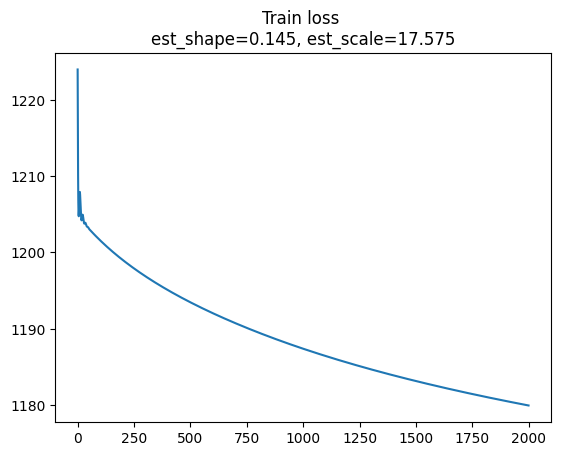

/opt/conda/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:2108: RuntimeWarning: divide by zero encountered in power
  return c*pow(x, c-1)*np.exp(-pow(x, c))


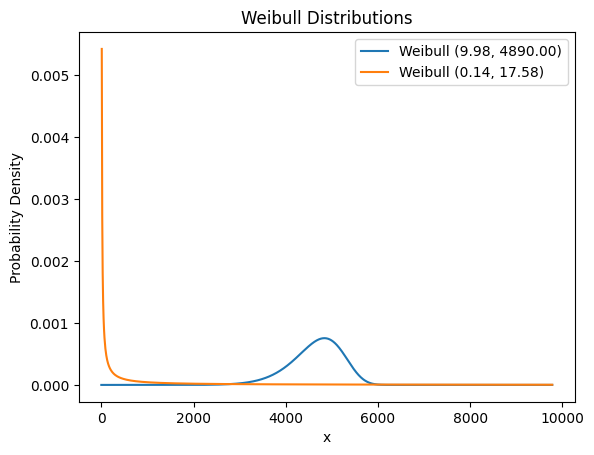

Actual shape=9.98


In [10]:
# min-max scale to speed up convergence. This means we won't get correctly estimated scale param, 
# but shape param will remain same. 
# weibull_data_scaled = [(x - weibull_data.min()) / (weibull_data.max() - weibull_data.min()) for x in weibull_data]
weibull_tensor = torch.tensor(weibull_data, dtype=float).reshape(-1,1)

m = Model()
opt = torch.optim.Adam(m.parameters(), lr=.01, amsgrad=True)
# opt = torch.optim.SGD(m.parameters(), lr=.1)

losses = train_loop(m, opt, data_tensor=weibull_tensor, n=2000)
losses = [loss.detach().numpy().tolist() for loss in losses]
fitted_params = m.weights

estimated_scale = fitted_params.detach().numpy()[0]
estimated_shape = fitted_params.detach().numpy()[1]
print(f'\nFitted params: shape={estimated_shape:.3f}, scale={estimated_scale:.3f}')
print(f'\nActual params: shape={shape}, scale={scale}')
print(f'\nabs(actual minus predicted) for shape={np.abs(shape-fitted_params[0].detach().numpy()):.2f}')
print(f'\nabs(actual minus predicted) for scale={np.abs(scale-fitted_params[1].detach().numpy()):.2f}')

txt = f'Train loss \nest_shape={estimated_shape:.3f}, est_scale={estimated_scale:.3f}'
plt.plot(losses)
plt.title(txt)
# plt.ylim(bottom=0)
plt.show()

plot_weibull_distributions((shape, scale), (estimated_shape, estimated_scale))
print(f'Actual shape={shape}')

# Using Adam optimizer on Beta data 

scale, shape, loss 

iter 0: 3.346547842025757, 3.581664562225342, 340.81355266112195
iter 100: 2.3480708599090576, 2.6817378997802734, 160.87962562713489
iter 200: 1.3448028564453125, 2.333920955657959, 42.27839850729825
iter 300: 0.9132375717163086, 2.8314480781555176, -6.73532838833715
iter 400: 0.9167470932006836, 3.3714661598205566, -20.608491645405092
iter 500: 0.9208517670631409, 3.843367338180542, -30.191360675610266
iter 600: 0.9242814779281616, 4.259122848510742, -37.085541812578654
iter 700: 0.927209198474884, 4.627406597137451, -42.180493514510204
iter 800: 0.9297372698783875, 4.954876899719238, -46.01755489422983
iter 900: 0.9319379925727844, 5.24686336517334, -48.947792964297676
iter 1000: 0.9338653683662415, 5.507749557495117, -51.20931270462113
iter 1100: 0.9355611801147461, 5.7412238121032715, -52.96924722410419
iter 1200: 0.9370588660240173, 5.950429916381836, -54.34792539400988
iter 1300: 0.9383854269981384, 6.138076305389404, -55.433731657484714
iter 1400: 0.9395632

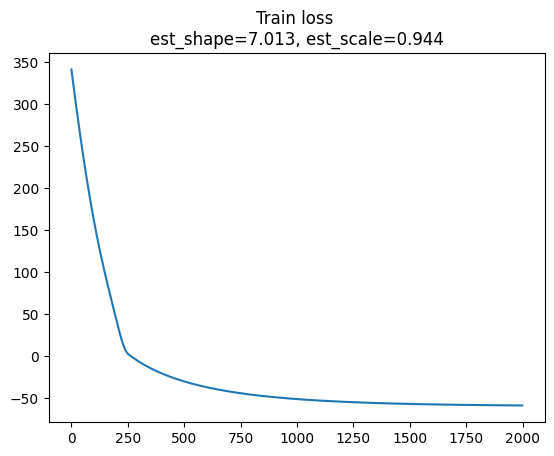

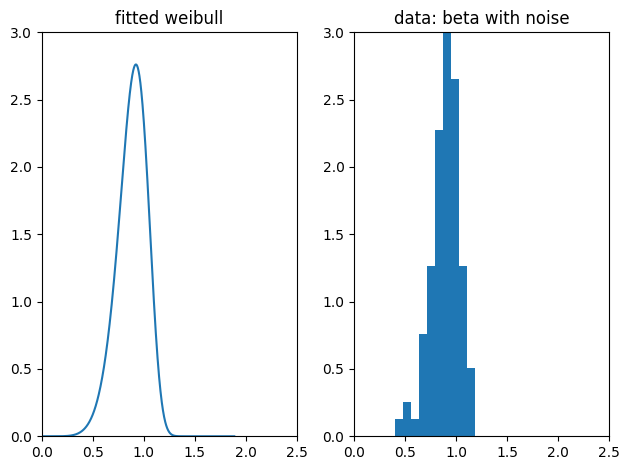

In [11]:
beta_tensor = torch.tensor(beta_data, dtype=float).reshape(-1,1)

m = Model()
opt = torch.optim.Adam(m.parameters(), lr=.01, amsgrad=True)
# opt = torch.optim.SGD(m.parameters(), lr=.1)

losses = train_loop(m, opt, data_tensor=beta_tensor, n=2000)
losses = [loss.detach().numpy().tolist() for loss in losses]
fitted_params = m.weights

estimated_scale = fitted_params.detach().numpy()[0]
estimated_shape = fitted_params.detach().numpy()[1]
print(f'\nFitted params: shape={estimated_shape:.3f}, scale={estimated_scale:.3f}')
# print(f'\nActual params: shape={shape}, scale={scale}')
# print(f'\nabs(actual minus predicted) for shape={np.abs(shape-fitted_params[0].detach().numpy()):.2f}')
# print(f'\nabs(actual minus predicted) for scale={np.abs(scale-fitted_params[1].detach().numpy()):.2f}')

txt = f'Train loss \nest_shape={estimated_shape:.3f}, est_scale={estimated_scale:.3f}'
plt.plot(losses)
plt.title(txt)
# plt.ylim(bottom=0)
plt.show()


txt = 'Fitted weibull vs beta_data_with_noise'
subs = ['fitted weibull', 'data: beta with noise']
fig, ax = plt.subplots(1, 2)
weibull_dist = weibull_min(c=estimated_shape, scale=estimated_scale)
x = np.linspace(0, estimated_scale*2, 1000)
weibull_pdf = weibull_dist.pdf(x)
ax[0].plot(x, weibull_pdf, label='fitted weibull')
ax[1].hist(beta_data, density=True)

for idx in range(2): 
    ax[idx].set_title(subs[idx])
    ax[idx].set_xlim(0, 2.5)
    ax[idx].set_ylim(0, 3.0)

fig.tight_layout()
fig.show()


****
# Using LBFGS optimizer on Weibull data 

scale, shape, loss 

iter 0: 2.88462495803833, 0.5102214813232422, 4846.484602208587
iter 0: 2.886979818344116, 0.4125763475894928, 2724.5826398347845
iter 0: 2.887115955352783, 0.40394729375839233, 2603.675169110428
iter 0: 2.887237787246704, 0.39178499579429626, 2446.801187435898
iter 0: 2.8872880935668945, 0.37987810373306274, 2307.387652660524
iter 0: 2.8872711658477783, 0.36806604266166687, 2181.7719130118426
iter 0: 2.8871891498565674, 0.3563673794269562, 2068.7886939766177
iter 0: 2.887044906616211, 0.34479355812072754, 1967.2875782894237
iter 0: 2.886841297149658, 0.3333575427532196, 1876.2259728845402
iter 0: 2.8865818977355957, 0.32207319140434265, 1794.6525934349295
iter 0: 2.88627028465271, 0.31095564365386963, 1721.7017778240079
iter 0: 2.8859105110168457, 0.3000210225582123, 1656.5830593540215
iter 0: 2.8855068683624268, 0.28928661346435547, 1598.575562442779
iter 0: 2.8850643634796143, 0.27877068519592285, 1547.020292980107
iter 0: 2.8845877647399902, 0.2684924900531769,

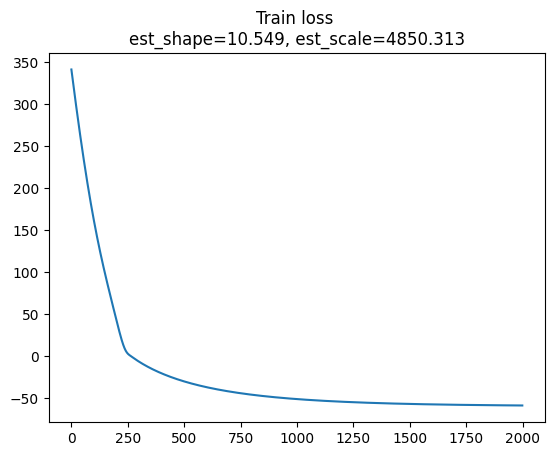

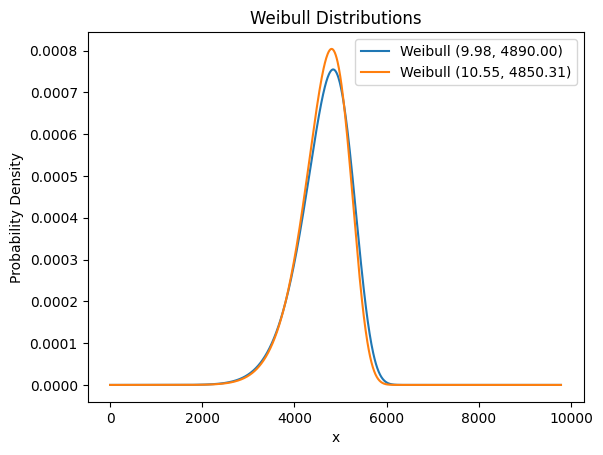

Actual shape=9.98


In [12]:
model2 = Model()

# Create the optimizer
optimizer = torch.optim.LBFGS(model2.parameters(), lr=0.1)

# Training loop
print('scale, shape, loss \n')
num_iterations = 2000
for i in range(num_iterations):
    def closure():
        optimizer.zero_grad()
        weibull_pdf = model2(weibull_tensor)
        lambda_, k = model2.weights
        loss = weibull_nll(weibull_tensor, lambda_, k)
        loss.backward()
        if i % 100 == 0 or i == num_iterations-1: 
            print(f'iter {i}: {lambda_}, {k}, {loss}')
        return loss

    optimizer.step(closure)

fitted_params = model2.weights
estimated_scale = fitted_params.detach().numpy()[0]
estimated_shape = fitted_params.detach().numpy()[1]
print(f'\nFitted params: shape={estimated_shape:.3f}, scale={estimated_scale:.3f}')
print(f'\nActual params: shape={shape}, scale={scale}')
print(f'\nabs(actual minus predicted) for shape={np.abs(shape-fitted_params[0].detach().numpy()):.2f}')
print(f'\nabs(actual minus predicted) for scale={np.abs(scale-fitted_params[1].detach().numpy()):.2f}')

txt = f'Train loss \nest_shape={estimated_shape:.3f}, est_scale={estimated_scale:.3f}'
plt.plot(losses)
plt.title(txt)
# plt.ylim(bottom=0)
plt.show()

plot_weibull_distributions((shape, scale), (estimated_shape, estimated_scale))
print(f'Actual shape={shape}')

****
# Using LBFGS optimizer on Beta data 

scale, shape, loss 

iter 0: 1.981414556503296, 2.8845620155334473, 125.85446424228542
iter 0: 1.9042105674743652, 2.8617660999298096, 114.92013375998118
iter 0: -11.293506622314453, -0.4887363314628601, nan
iter 0: nan, nan, nan
iter 0: nan, nan, nan
iter 0: nan, nan, nan
iter 0: nan, nan, nan
iter 0: nan, nan, nan
iter 0: nan, nan, nan
iter 0: nan, nan, nan
iter 0: nan, nan, nan
iter 0: nan, nan, nan
iter 0: nan, nan, nan
iter 0: nan, nan, nan
iter 0: nan, nan, nan
iter 0: nan, nan, nan
iter 0: nan, nan, nan
iter 0: nan, nan, nan
iter 0: nan, nan, nan
iter 0: nan, nan, nan
iter 100: nan, nan, nan
iter 100: nan, nan, nan
iter 100: nan, nan, nan
iter 100: nan, nan, nan
iter 100: nan, nan, nan
iter 100: nan, nan, nan
iter 100: nan, nan, nan
iter 100: nan, nan, nan
iter 100: nan, nan, nan
iter 100: nan, nan, nan
iter 100: nan, nan, nan
iter 100: nan, nan, nan
iter 100: nan, nan, nan
iter 100: nan, nan, nan
iter 100: nan, nan, nan
iter 100: nan, nan, nan
iter 100: nan, nan, nan
iter 100: 

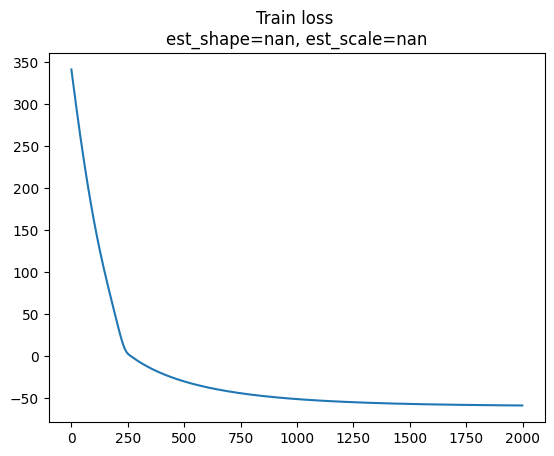

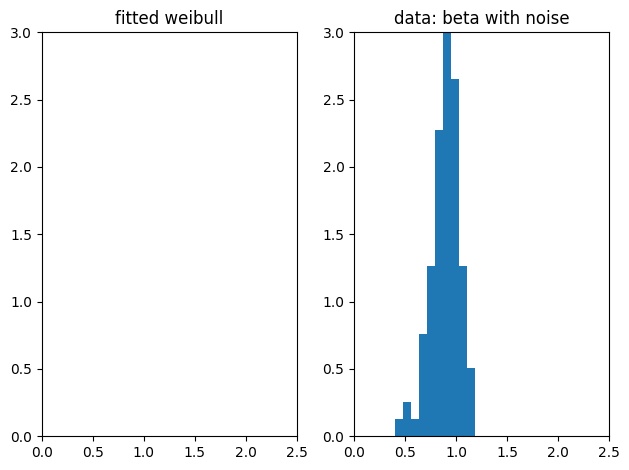

In [13]:
model2 = Model()

# Create the optimizer
optimizer = torch.optim.LBFGS(model2.parameters(), lr=0.1)

# Training loop
print('scale, shape, loss \n')
num_iterations = 2000
for i in range(num_iterations):
    def closure():
        optimizer.zero_grad()
        weibull_pdf = model2(beta_tensor)
        lambda_, k = model2.weights
        loss = weibull_nll(beta_tensor, lambda_, k)
        loss.backward()
        if i % 100 == 0 or i == num_iterations-1: 
            print(f'iter {i}: {lambda_}, {k}, {loss}')
        return loss

    optimizer.step(closure)

fitted_params = model2.weights
estimated_scale = fitted_params.detach().numpy()[0]
estimated_shape = fitted_params.detach().numpy()[1]
print(f'\nFitted params: shape={estimated_shape:.3f}, scale={estimated_scale:.3f}')
print(f'\nActual params: shape={shape}, scale={scale}')
print(f'\nabs(actual minus predicted) for shape={np.abs(shape-fitted_params[0].detach().numpy()):.2f}')
print(f'\nabs(actual minus predicted) for scale={np.abs(scale-fitted_params[1].detach().numpy()):.2f}')

txt = f'Train loss \nest_shape={estimated_shape:.3f}, est_scale={estimated_scale:.3f}' 
plt.plot(losses)
plt.title(txt)
# plt.ylim(bottom=0)
plt.show()

txt = 'Fitted weibull vs beta_data_with_noise'
subs = ['fitted weibull', 'data: beta with noise']
fig, ax = plt.subplots(1, 2)
weibull_dist = weibull_min(c=estimated_shape, scale=estimated_scale)
x = np.linspace(0, estimated_scale*2, 1000)
weibull_pdf = weibull_dist.pdf(x)
ax[0].plot(x, weibull_pdf, label='fitted weibull')
ax[1].hist(beta_data, density=True)

for idx in range(2): 
    ax[idx].set_title(subs[idx])
    ax[idx].set_xlim(0, 2.5)
    ax[idx].set_ylim(0, 3.0)

fig.tight_layout()
fig.show()

****
# Random stuff 

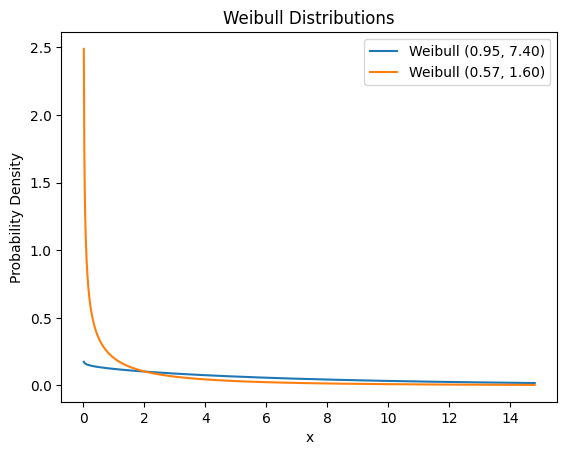

In [14]:
plot_weibull_distributions((.95, 7.4), (.57, 1.6))